# MLP (Multilayer Perceptron)

In [331]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [332]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [333]:
len(words)

32033

In [334]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [335]:
block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], []
for w in words:
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for  i in context), '--->', itos[ix])
        context = context[1:]+[ix] # crop and append
        
    
X = torch.tensor(X)
Y = torch.tensor(Y)

In [336]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [337]:
# building the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [338]:
C = torch.randn((27,2))

In [339]:
C[5]

tensor([-0.0622, -0.2273])

In [340]:
C[torch.tensor([5,6,7])]

tensor([[-0.0622, -0.2273],
        [ 0.8207, -2.0554],
        [ 1.2053,  0.9979]])

In [341]:
C[X].shape

torch.Size([228146, 3, 2])

In [342]:
X[13,2]

tensor(1)

In [343]:
C[X][13,2]

tensor([ 0.0375, -0.1532])

In [344]:
C[1]

tensor([ 0.0375, -0.1532])

In [345]:
emb = C[X]

In [346]:
W1 = torch.randn((6, 100)) #first index is 3x2 derived from C[X].shape having dimension [32,3,2] 6 = 3x2
                           # second index is number of neurons (flexible)
b1 = torch.randn(100) # biases = no. of neurons

In [347]:
 h = torch.tanh(emb.view(-1,6) @ W1 + b1) #  PyTorch will automatically derive the second parameter at -1

In [348]:
h

tensor([[ 0.3790, -0.8871,  0.9106,  ..., -0.9548,  0.9853,  0.9974],
        [-0.0622,  0.3873,  0.8306,  ..., -0.8193,  0.9792,  0.9704],
        [ 0.9713, -0.9892,  0.9215,  ...,  0.3881,  0.9680,  0.9888],
        ...,
        [-0.3964, -0.4660,  0.6134,  ...,  0.9978, -0.9981, -0.0685],
        [-0.9940,  0.9990, -0.6403,  ..., -0.8020, -0.9999,  0.7979],
        [ 0.9995, -0.9997,  0.8792,  ...,  0.9834, -0.1617,  0.9487]])

In [349]:
h.shape

torch.Size([228146, 100])

In [350]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [351]:
logits = h @ W2 + b2

In [352]:
logits.shape

torch.Size([228146, 27])

In [353]:
counts = logits.exp()

In [354]:
prob = counts / counts.sum(1, keepdims = True)

In [355]:
prob.shape

torch.Size([228146, 27])

In [356]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [367]:
g = torch.Generator().manual_seed(2147483647) # for reporducibility
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator =g )
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27,  generator = g)
parameters = [C, W1, b1, W2, b2]

In [368]:
sum(p.nelement() for p in parameters ) # number of total parameters

11897

In [369]:
for p in parameters:
    p.requires_grad = True

In [370]:
# Figure out learning rate

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [371]:
lri = []
lossi = []
for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims = True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # Never use the above commented lines, instead use `F.cross_entropy`
    loss = F.cross_entropy(logits, Ytr[ix])

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
#     lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data+= -lr*p.grad
        
    # track stats
#     lri.append(lr)
#     lossi.append(loss.item())
        
print(loss.item())

2.530311107635498


In [373]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) 
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1204, grad_fn=<NllLossBackward0>)

In [374]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1662, grad_fn=<NllLossBackward0>)

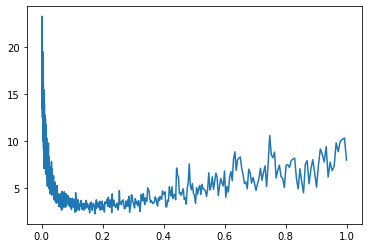

In [268]:
plt.plot(lri, lossi)

We notice that the appropriate learning rate is somewhere between 0.0 and 0.2

In [214]:
X.shape

torch.Size([228146, 3])

In [132]:
X[228145]

tensor([25, 26, 24])

In [133]:
C[[25, 26, 24]]

tensor([[-1.4904, -0.2838],
        [ 0.2569,  0.2130],
        [-0.5132,  0.2961]], grad_fn=<IndexBackward0>)

In [135]:
Y.shape

torch.Size([228146])

In [136]:
logits.shape

torch.Size([32, 27])

In [388]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+666)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

lainoa.
shi.
noan.
hold.
telee.
kea.
iza.
mika.
alin.
crashao.
mas.
kri.
cla.
lillavya.
mirayli.
srobainah.
cayl.
juvit.
damiileig.
raitiah.
